# Inicialização

In [130]:
from itertools import product
import re
import time
import unicodedata

import yaml
import numpy as np
import pandas as pd
from sklearn.decomposition.nmf import ProjectedGradientNMF
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import TweetTokenizer

In [113]:
from bokeh.models import ColumnDataSource
import bokeh.plotting


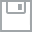
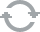
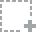
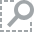
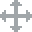
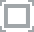
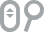
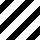
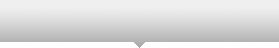
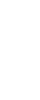
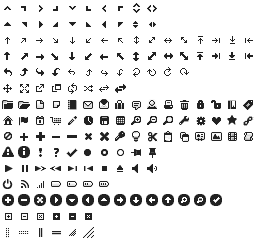
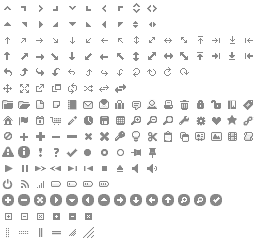
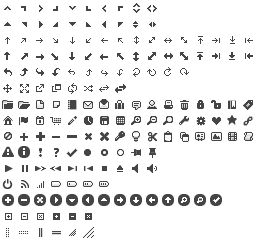
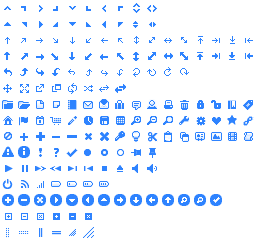
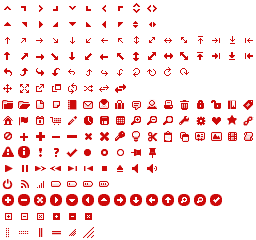
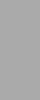
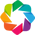
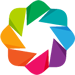

In [114]:
bokeh.plotting.output_notebook()

In [3]:
import elasticsearch
from elasticsearch.helpers import scan, bulk

In [4]:
# Usar tunel
# $ ssh ubuntu@twitter-es.twist.systems -L10200:localhost:9200
es_conn = elasticsearch.Elasticsearch("localhost:10200", timeout=300)
es_conn.ping()

True

# Tokenização

In [5]:
def doc_to_tweet(docs):
    for doc in docs:
        text = doc['_source'].get('text', '')
        if text:
            yield text

In [6]:
TOKENIZER = TweetTokenizer()
RE_JAJA = re.compile('^[jae]{2,}$')

def filter_tokens(tokens):
    
    for token in tokens:
        if RE_JAJA.match(token.lower()):
            yield "jaja"
        else:
            yield token

def tokenize_tweets(tweets):
    tokenizer = TOKENIZER
    for tweet in tweets:
        # Perform normalization of unicode characters
        #tweet = unicodedata.normalize("NFC", tweet)
        tweet = ''.join(unicodedata.normalize('NFD', x)[0] for x in tweet)

        tokens = tokenizer.tokenize(tweet)
  
        yield list(filter_tokens(tokens))

In [7]:
query = yaml.safe_load("""
query:
    filtered:
        filter:
            bool:
                must:
                - term:
                    user: tuenti
_source:
    include:
    - user_info.screen_name
    - created_at
    - text
    - id
""")

docs = scan(es_conn, index="twitter", doc_type="tweet", query=query, size=1000)
docs_df = pd.DataFrame.from_dict(
    (
        {
            "twitter_id": doc["_source"]["id"],
            "screen_name": doc["_source"]["user_info"]["screen_name"],
            "created_at": pd.to_datetime(doc["_source"]["created_at"]),
            "text": doc["_source"].get("text","")
        } for doc in docs),
    orient="columns"
)

In [8]:
# Tokenize
docs_df['tokenized'] = pd.Series(tokenize_tweets(docs_df['text'].values), index=docs_df.index)

In [132]:
docs_df.to_pickle('tweets_tuenti_tokenized.p')

# Montagem da matriz de documentos

In [11]:
wordlist = pd.read_pickle('wordlist.p')

In [16]:
wordlist_indices = dict(tuple(reversed(x)) for x in enumerate(wordlist))

In [17]:
doc_mat = np.zeros((docs_df.shape[0], len(wordlist)))

In [21]:
for idx_row, tokens in enumerate(docs_df['tokenized'].values):
    for token in tokens:
        token = token.lower()
        if token not in wordlist_indices:
            continue
            
        idx_token = wordlist_indices[token]
        doc_mat[idx_row, idx_token] = 1.0

In [30]:
doc_mat_norm = normalize(doc_mat)

In [33]:
S = np.dot(doc_mat_norm.T, doc_mat_norm)

In [34]:
S.shape

(833, 833)

In [39]:
D = np.power(np.sum(S, axis=1), -0.5) * np.eye(S.shape[0])

In [41]:
Y = np.dot(D, doc_mat.T)

In [42]:
Y.shape

(833, 8994)

# Cálculo da NMF

In [122]:
def edges_sum(cond_1, cond_2, S):
    nodes_1 = np.where(cond_1)[0]
    nodes_2 = np.where(cond_2)[0]
    
    indices = product(nodes_1, nodes_2)
    return np.sum(S[idx] for idx in indices)


def n_cut(mat_U, mat_S):
    
    term_clusters = mat_U.argmax(axis=1)
    
    n_k = mat_U.shape[1]
    
    result = 0.0
    for idx_k in range(n_k):
        
        cond_g_k = term_clusters == idx_k
        num = edges_sum(cond_g_k, ~cond_g_k, mat_S)
        den = edges_sum(cond_g_k,  cond_g_k, mat_S) + num
        
        result += num/den
        
    return 0.5 * result
    

In [127]:
models = {}

source = ColumnDataSource(data={"x": [0], "y": [0]})

plot = bokeh.plotting.figure(title="Ncut", plot_height=500, plot_width=900)
plot.line(source.data['x'], source.data['y'], color="#2222aa", line_width=2, source=source)
plot.circle(source.data['x'], source.data['y'], color="#2222aa", fill_color="white", size=8, source=source)
bokeh.plotting.show(plot)

In [129]:
for k in range(50, 100):
    
    start_time = time.time()
    model = ProjectedGradientNMF(n_components=k, init="nndsvda", max_iter=1000)
    V_T = model.fit_transform(Y.T)
    U_T = model.components_
    n_cut_val = n_cut(U_T.T, S)
    
    models[k] = {
        "model": model,
        "V_T": V_T,
        "n_cut": n_cut_val,
    }
    end_time = time.time()
    
    print("%d: %f" %(k, end_time - start_time))
    
    source.data['x'] = sorted(models.keys())
    source.data['y'] = [models[x]["n_cut"]/x for x in source.data['x']]
    source.push_notebook()

50: 36.173469


51: 51.039301


52: 33.753461


53: 35.273318


54: 51.907767


55: 35.000838


56: 125.555817


57: 33.966575


58: 29.772880


59: 28.446615


60: 32.946164


61: 77.511077


62: 80.620305


63: 45.902750


64: 43.777914


65: 28.735131


66: 48.062439


67: 28.167820


68: 43.646682


69: 41.528814


70: 47.709809


71: 59.837342


72: 54.264010


73: 32.262103


74: 48.251229


75: 99.697600


76: 53.333471


77: 70.415788


78: 54.395765


79: 46.379657


80: 86.517928


81: 78.968141


82: 37.341716


83: 20.800484


84: 17.375600


85: 42.952324


86: 53.961044


87: 38.074561


88: 26.631878


89: 39.485881


90: 56.834340


91: 87.365774


92: 55.701867


93: 23.773657


94: 86.036797


95: 60.408974


96: 83.216126


97: 59.834807


98: 94.054666


99: 43.513856
